# Varying model parameters to vary host prevalence ($X_H$)
----


In those notebook I vary three different model parameters -- the biting rate, the number of vectors, and the host clearance rate -- in order to produce a variation in host prevalence. Using the analytical expression for host prevalence at equilibrium, I vary those parameters to produce host prevalence values ranging from 0.1 to 0.9.

The notebook begins by loading a "base parameter set", from which the aforementioned parameters are individually varied. At the end, I write shell scripts that allow for automatic generation of appropriate parameter file in the `/params` directory.

In [1]:
import numpy as np
import pandas as pd
import os
import stat
import json
from collections import Counter
from collections import OrderedDict

import allel
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

# inline stylization
%matplotlib inline
sns.set_style('white')
sns.set_style('ticks')
#sns.set_style("ticks")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

In [2]:
from lib.diagnostics import *

In [3]:
savefig = True

# I. Load Data

In [4]:
param_file = "param_correlation-nh500.ini"
param_path = os.path.join("../params", param_file)

## a. Parse Base Parameter Set

In [5]:
# ASSIGN SIMULATION PARAMETERS
config = configparser.ConfigParser()
config.read(param_path)
# Basic
params = {}
demography = {param: int(val) for param, val in config.items('Demography')}
transmission = {param: float(val) for param, val in config.items('Transmission')}
genome = {param: int(val) for param, val in config.items('Genome')}
evolution = {param: float(val) for param, val in config.items('Evolution')}
params.update(demography)
params.update(transmission)
params.update(genome)
params.update(evolution)
# Derived & Equilibrium
derived_params = calc_derived_params(params)
equil_params = calc_equil_params(params, derived_params)
x_h = calc_x_h(**equil_params)
x_v = calc_x_v(**equil_params)
# Options
options = {}
options['back_mutation'] = config.getboolean('Options', 'back_mutation')
options['max_samples'] = eval(config.get('Options', 'max_samples'))
options['detection_threshold'] = eval(config.get('Options', 'detection_threshold'))

In [6]:
print("Parameter Values")
print("  No. of Humans:", params['nh'])
print("  No. of Vectors:", params['nv'])
print("  No. of Parasites per Human:", params['nph'])
print("  No. of Parasites per Vector:", params['npv'])
print("  No. Sites in Parasite Genome:", params['nsnps'])
print("  Bite Rate per Vector:", params['bite_rate_per_v'])
print("  Prob. Human Infected per Bite:", params['p_inf_h'])
print("  Prob. Vector Infected per Bite:", params['p_inf_v'])
print("  Drift Rate in Humans:", params['drift_rate_h'])
print("  Drift Rate in Vectors:", params['drift_rate_v'])
print("  Mutation Rate in Humans (theta):", params['theta_h'])
print("  Mutation Rate in Vectors (theta):", params['theta_v'])
print("  Rate of Human Clearance (gamma):", params['gamma'])
print("  Rate of Vector Clearance (eta):", params['eta'])
print("  Lambda:", derived_params['lmbda'])
print("  Psi:", derived_params['psi'])
print("  Expected Human Prevalence:", x_h)
print("  Expected Vector Prevalence:", x_v)
print("    Run with back mutation?", options['back_mutation'])
print("    Limit number of samples collected to:", options['max_samples'])
print("    Set the detection threshold for mixed infections to:", options['detection_threshold'])

Parameter Values
  No. of Humans: 500
  No. of Vectors: 2500
  No. of Parasites per Human: 10
  No. of Parasites per Vector: 10
  No. Sites in Parasite Genome: 1000
  Bite Rate per Vector: 0.25
  Prob. Human Infected per Bite: 0.1
  Prob. Vector Infected per Bite: 0.1
  Drift Rate in Humans: 1.0
  Drift Rate in Vectors: 1.0
  Mutation Rate in Humans (theta): 0.0001
  Mutation Rate in Vectors (theta): 0.0001
  Rate of Human Clearance (gamma): 0.005
  Rate of Vector Clearance (eta): 0.2
  Lambda: 0.125
  Psi: 0.025
  Expected Human Prevalence: 0.6538461538461539
  Expected Vector Prevalence: 0.07555555555555556
    Run with back mutation? True
    Limit number of samples collected to: 20
    Set the detection threshold for mixed infections to: 0.05


# II. Set Prevalence Array

In [7]:
prevs = np.arange(0.1, 0.9, 0.1)

# III. Vary Metrics

## a. Number of Vectors ($nv$)

In [8]:
orig_nv = params["nv"]

In [9]:
def nv_at_x_h(x_h, params):
    """
    Solve for the number of vectors `nv` that will
    give a desired host prevalence `x_h`
    given a parameter set.
    """
    a = params["gamma"]*params["eta"]
    b = x_h*params["gamma"]*params["bite_rate_per_v"]*params["p_inf_v"]
    c = (params["bite_rate_per_v"]**2)*params["p_inf_h"]*params["p_inf_v"]*(1 - x_h)
    return params["nh"]*(a + b)/c

In [10]:
nv_dt = {
    "prevs": [],
    "nv": [],
    "x_h": [],
    "x_v": [],
    "t_equil": []
}
column_ord = ["prevs", "nv", "x_h", "x_v", "t_equil"]

In [11]:
nvs = nv_at_x_h(prevs, params)
for prev, nv in zip(prevs, nvs):
    # Update parameters
    params.update({"nv": nv})
    derived_params = calc_derived_params(params)
    equil_params = calc_equil_params(params, derived_params)
    # Recalculate prevalences
    x_h = calc_x_h(**equil_params) 
    x_v = calc_x_v(**equil_params)
    # Calculate estimated time to equilibrium
    t_equil = 2*x_h*params['nh']*(derived_params['h_v'] + derived_params['v_h'])  # 2*Ne*g
    # Store
    nv_dt["prevs"].append(prev)
    nv_dt["nv"].append(nv)
    nv_dt["x_h"].append(x_h)
    nv_dt["x_v"].append(x_v)
    nv_dt["t_equil"].append(t_equil)
    
params.update({"nv" : orig_nv})
derived_params = calc_derived_params(params)
equil_params = calc_equil_params(params, derived_params)

In [12]:
nv_df = pd.DataFrame(nv_dt)
nv_df = nv_df[column_ord]

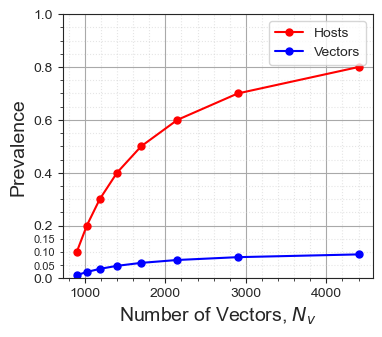

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))

ax.plot(nv_df["nv"], nv_df["x_h"], color='red', marker='o', markersize=5, label='Hosts')
ax.plot(nv_df["nv"], nv_df["x_v"], color='blue', marker='o', markersize=5, label='Vectors')


ax.yaxis.set_minor_formatter(plt.FuncFormatter(lambda val, num: "%.02f" % val if num <= 2 else ""))
ax.tick_params('y', which='minor', labelsize=8)
ax.tick_params('x', which='minor', labelsize=8)
ax.minorticks_on()
# grid
ax.grid(which='major', linestyle='solid', color='darkgrey')
ax.grid(which='minor', linestyle='dotted', alpha=0.5)
# limits
ax.set_ylim((0, 1))
# labels
ax.set_ylabel("Prevalence", fontsize=14)
ax.set_xlabel("Number of Vectors, $N_v$", fontsize=14)

ax.legend(frameon=True)

if savefig:
    fig.savefig("../figs/sec2_gen-variable-prevalence-nv.pdf", 
                bbox_inches="tight", 
                pad_inches=0.5)

## b. Human Clearance Rate ($\gamma$)

In [14]:
orig_gamma = params["gamma"]

In [15]:
def gamma_at_x_h(x_h, params, derived_params):
    """
    Solve for `gamma` that will give a
    desired `x_h` given a set of derived parameters
    """
    a = derived_params['lmbda']*derived_params['psi']*(1 - x_h)
    b = derived_params['psi']*x_h + params['eta']
    return a/b

In [16]:
gamma_dt = {
    "prevs": [],
    "gamma": [],
    "x_h": [],
    "x_v": [],
    "t_equil": []
}
column_ord = ["prevs", "gamma", "x_h", "x_v", "t_equil"]

These all look reasonable

In [17]:
# Calculate `nv` matching `x_h`
gammas = gamma_at_x_h(prevs, params, derived_params)
for prev, gamma in zip(prevs, gammas):
    # Update parameters
    params.update({"gamma": gamma})
    derived_params = calc_derived_params(params)
    equil_params = calc_equil_params(params, derived_params)
    # Recalculate prevalences
    x_h = calc_x_h(**equil_params) 
    x_v = calc_x_v(**equil_params)
    # Calculate estimated time to equilibrium
    t_equil = 2*x_h*params['nh']*(derived_params['h_v'] + derived_params['v_h'])  # 2*Ne*g
    # Store
    gamma_dt["prevs"].append(prev)
    gamma_dt["gamma"].append(gamma)
    gamma_dt["x_h"].append(x_h)
    gamma_dt["x_v"].append(x_v)
    gamma_dt["t_equil"].append(t_equil)
    
params.update({"gamma" : orig_gamma})
derived_params = calc_derived_params(params)
equil_params = calc_equil_params(params, derived_params)

In [18]:
gamma_df = pd.DataFrame(gamma_dt)
gamma_df = gamma_df[column_ord]

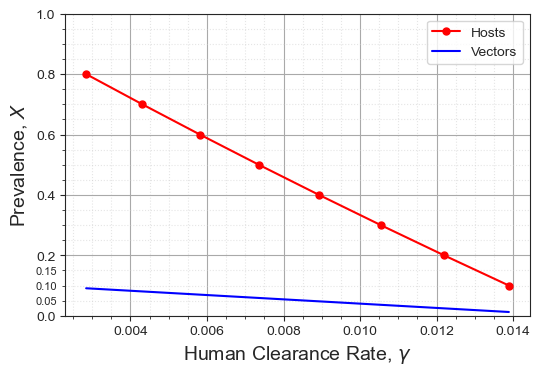

In [19]:
fig, ax = plt.subplots(1, 1)

ax.plot(gamma_df["gamma"], gamma_df["x_h"], color='red', marker='o', markersize=5, label='Hosts')
ax.plot(gamma_df["gamma"], gamma_df["x_v"], color='blue', label='Vectors')


ax.yaxis.set_minor_formatter(plt.FuncFormatter(lambda val, num: "%.02f" % val if num <= 2 else ""))
ax.tick_params('y', which='minor', labelsize=8)
ax.tick_params('x', which='minor', labelsize=8)
ax.minorticks_on()
# grid
ax.grid(which='major', linestyle='solid', color='darkgrey')
ax.grid(which='minor', linestyle='dotted', alpha=0.5)
# limits
ax.set_ylim((0, 1))
# labels
ax.set_ylabel("Prevalence, $X$", fontsize=14)
ax.set_xlabel("Human Clearance Rate, $\gamma$", fontsize=14)

ax.legend(frameon=True)

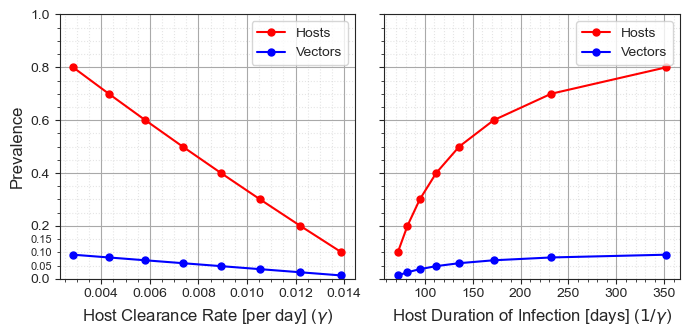

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5), sharey=True)
fig.subplots_adjust(wspace=0.1)


# Rate
ax[0].plot(gamma_df["gamma"], gamma_df["x_h"], color='red', marker='o', markersize=5, label='Hosts')
ax[0].plot(gamma_df["gamma"], gamma_df["x_v"], color='blue', marker='o', markersize=5, label='Vectors')

ax[0].yaxis.set_minor_formatter(plt.FuncFormatter(lambda val, num: "%.02f" % val if num <= 2 else ""))
ax[0].tick_params('y', which='minor', labelsize=8)
ax[0].tick_params('x', which='minor', labelsize=8)
ax[0].minorticks_on()
# grid
ax[0].grid(which='major', linestyle='solid', color='darkgrey')
ax[0].grid(which='minor', linestyle='dotted', alpha=0.5)
# limits
ax[0].set_ylim((0, 1))
# labels
ax[0].set_ylabel("Prevalence", fontsize=12)
ax[0].set_xlabel("Host Clearance Rate [per day] ($\gamma$)", fontsize=12)
ax[0].legend(frameon=True)


# Duration
ax[1].plot(1/gamma_df["gamma"], gamma_df["x_h"], color='red', marker='o', markersize=5, label='Hosts')
ax[1].plot(1/gamma_df["gamma"], gamma_df["x_v"], color='blue', marker='o', markersize=5, label='Vectors')

ax[1].yaxis.set_minor_formatter(plt.FuncFormatter(lambda val, num: "%.02f" % val if num <= 2 else ""))
ax[1].tick_params('y', which='minor', labelsize=8)
ax[1].tick_params('x', which='minor', labelsize=8)
ax[1].minorticks_on()
# grid
ax[1].grid(which='major', linestyle='solid', color='darkgrey')
ax[1].grid(which='minor', linestyle='dotted', alpha=0.5)
# limits
ax[1].set_ylim((0, 1))
# labels
ax[1].set_xlabel("Host Duration of Infection [days] ($1/\gamma$)", fontsize=12)
ax[1].legend(frameon=True)

if savefig:
    fig.savefig("../figs/sec2_gen-variable-prevalence-gamma.pdf", 
                bbox_inches="tight", 
                pad_inches=0.5)

## c. Vector biting rate ($b_{r}$)

In [21]:
orig_br = params["bite_rate_per_v"]

In [22]:
equil_params

{'lmbda': 0.125, 'psi': 0.025, 'gamma': 0.005, 'eta': 0.2}

In [23]:
def bite_rate_per_v_at_x_h(x_h, params, derived_params):
    """
    Solve for `bite_rate_per_v` that will give a
    desired `x_h` given a set of derived parameters
    
    Requires solving a quadratic equation
    
    """
    
    a = (params["nv"]/params["nh"])*params["p_inf_h"]*params["p_inf_v"]*(x_h - 1)
    b = x_h*params["gamma"]*params["p_inf_v"]
    c = params["gamma"]*params["eta"]
    
    num = -b - np.sqrt(b**2 - 4*a*c)
    denom = 2*a
    return num/denom

In [24]:
br_dt = {
    "prevs": [],
    "br": [],
    "x_h": [],
    "x_v": [],
    "t_equil": []
}
column_ord = ["prevs", "br", "x_h", "x_v", "t_equil"]

In [25]:
# Calculate `nv` matching `x_h`
brs = bite_rate_per_v_at_x_h(prevs, params, derived_params)
for prev, br in zip(prevs, brs):
    # Update parameters
    params.update({"bite_rate_per_v": br})
    derived_params = calc_derived_params(params)
    equil_params = calc_equil_params(params, derived_params)
    # Recalculate prevalences
    x_h = calc_x_h(**equil_params) 
    x_v = calc_x_v(**equil_params)
    # Calculate estimated time to equilibrium
    t_equil = 2*x_h*params['nh']*(derived_params['h_v'] + derived_params['v_h'])  # 2*Ne*g
    # Store
    br_dt["prevs"].append(prev)
    br_dt["br"].append(br)
    br_dt["x_h"].append(x_h)
    br_dt["x_v"].append(x_v)
    br_dt["t_equil"].append(t_equil)
    
params.update({"bite_rate_per_v" : orig_br})
derived_params = calc_derived_params(params)
equil_params = calc_equil_params(params, derived_params)

In [26]:
br_df = pd.DataFrame(br_dt)
br_df = br_df[column_ord]

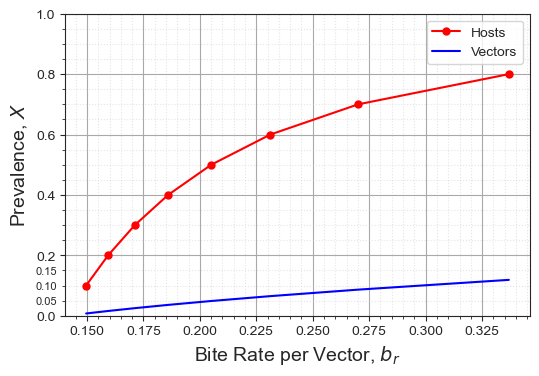

In [27]:
fig, ax = plt.subplots(1, 1)

ax.plot(br_df["br"], br_df["x_h"], color='red', marker='o', markersize=5, label='Hosts')
ax.plot(br_df["br"], br_df["x_v"], color='blue', label='Vectors')


ax.yaxis.set_minor_formatter(plt.FuncFormatter(lambda val, num: "%.02f" % val if num <= 2 else ""))
ax.tick_params('y', which='minor', labelsize=8)
ax.tick_params('x', which='minor', labelsize=8)
ax.minorticks_on()
# grid
ax.grid(which='major', linestyle='solid', color='darkgrey')
ax.grid(which='minor', linestyle='dotted', alpha=0.5)
# limits
ax.set_ylim((0, 1))
# labels
ax.set_ylabel("Prevalence, $X$", fontsize=14)
ax.set_xlabel("Bite Rate per Vector, $b_r$", fontsize=14)

ax.legend(frameon=True)

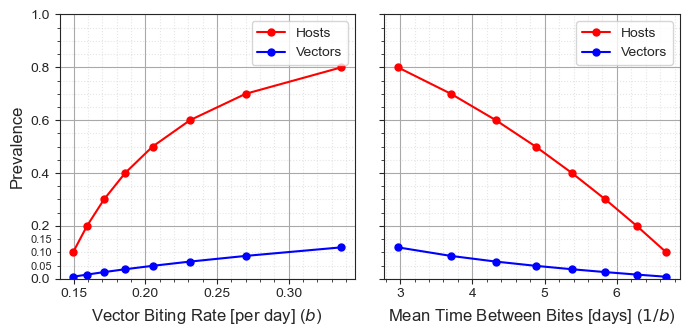

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5), sharey=True)
fig.subplots_adjust(wspace=0.1)


# Rate
ax[0].plot(br_df["br"], br_df["x_h"], color='red', marker='o', markersize=5, label='Hosts')
ax[0].plot(br_df["br"], br_df["x_v"], color='blue', marker='o', markersize=5, label='Vectors')

ax[0].yaxis.set_minor_formatter(plt.FuncFormatter(lambda val, num: "%.02f" % val if num <= 2 else ""))
ax[0].tick_params('y', which='minor', labelsize=8)
ax[0].tick_params('x', which='minor', labelsize=8)
ax[0].minorticks_on()
# grid
ax[0].grid(which='major', linestyle='solid', color='darkgrey')
ax[0].grid(which='minor', linestyle='dotted', alpha=0.5)
# limits
ax[0].set_ylim((0, 1))
# labels
ax[0].set_ylabel("Prevalence", fontsize=12)
ax[0].set_xlabel("Vector Biting Rate [per day] ($b$)", fontsize=12)
ax[0].legend(frameon=True)


# Duration
ax[1].plot(1/br_df["br"], br_df["x_h"], color='red', marker='o', markersize=5, label='Hosts')
ax[1].plot(1/br_df["br"], br_df["x_v"], color='blue', marker='o', markersize=5, label='Vectors')

ax[1].yaxis.set_minor_formatter(plt.FuncFormatter(lambda val, num: "%.02f" % val if num <= 2 else ""))
ax[1].tick_params('y', which='minor', labelsize=8)
ax[1].tick_params('x', which='minor', labelsize=8)
ax[1].minorticks_on()
# grid
ax[1].grid(which='major', linestyle='solid', color='darkgrey')
ax[1].grid(which='minor', linestyle='dotted', alpha=0.5)
# limits
ax[1].set_ylim((0, 1))
# labels
ax[1].set_xlabel("Mean Time Between Bites [days] ($1/b$)", fontsize=12)
ax[1].legend(frameon=True)

if savefig:
    fig.savefig("../figs/sec2_gen-variable-prevalence-br.pdf", 
                bbox_inches="tight", 
                pad_inches=0.5)

## d. Plots side-by-side

Text(0.5, 0, 'Bite Rate per Vector, $b$')

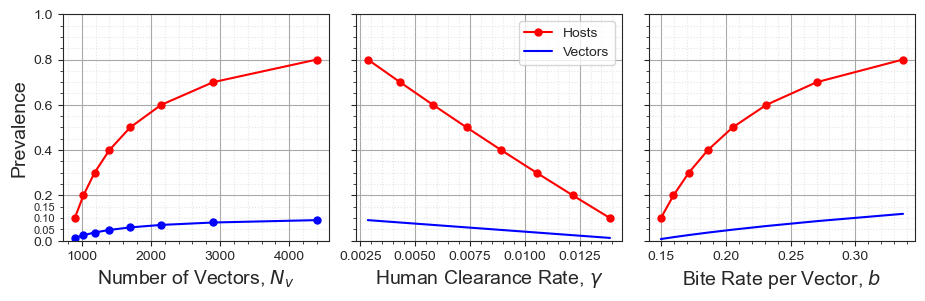

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(11, 3), sharey=True)
fig.subplots_adjust(wspace=0.1)


# Number of Vectors
ax[0].plot(nv_df["nv"], nv_df["x_h"], color='red', marker='o', markersize=5, label='Hosts')
ax[0].plot(nv_df["nv"], nv_df["x_v"], color='blue', marker='o', markersize=5, label='Vectors')
# ticks
ax[0].yaxis.set_minor_formatter(plt.FuncFormatter(lambda val, num: "%.02f" % val if num <= 2 else ""))
ax[0].tick_params('y', which='minor', labelsize=8)
ax[0].tick_params('x', which='minor', labelsize=8)
ax[0].minorticks_on()
# grid
ax[0].grid(which='major', linestyle='solid', color='darkgrey')
ax[0].grid(which='minor', linestyle='dotted', alpha=0.5)
# limits
ax[0].set_ylim((0, 1))
# labels
ax[0].set_ylabel("Prevalence", fontsize=14)
ax[0].set_xlabel("Number of Vectors, $N_v$", fontsize=14)


# Human Clearance Rate
ax[1].plot(gamma_df["gamma"], gamma_df["x_h"], color='red', marker='o', markersize=5, label='Hosts')
ax[1].plot(gamma_df["gamma"], gamma_df["x_v"], color='blue', label='Vectors')
# ticks
ax[1].tick_params('y', which='minor', labelsize=8)
ax[1].tick_params('x', which='minor', labelsize=8)
ax[1].minorticks_on()
# grid
ax[1].grid(which='major', linestyle='solid', color='darkgrey')
ax[1].grid(which='minor', linestyle='dotted', alpha=0.5)
# limits
ax[1].set_ylim((0, 1))
# labels
ax[1].set_xlabel("Human Clearance Rate, $\gamma$", fontsize=14)
# legend
ax[1].legend(frameon=True)


# Biting Rate
ax[2].plot(br_df["br"], br_df["x_h"], color='red', marker='o', markersize=5, label='Hosts')
ax[2].plot(br_df["br"], br_df["x_v"], color='blue', label='Vectors')
# ticks
ax[2].tick_params('y', which='minor', labelsize=8)
ax[2].tick_params('x', which='minor', labelsize=8)
ax[2].minorticks_on()
# grid
ax[2].grid(which='major', linestyle='solid', color='darkgrey')
ax[2].grid(which='minor', linestyle='dotted', alpha=0.5)
# limits
ax[2].set_ylim((0, 1))
# labels
ax[2].set_xlabel("Bite Rate per Vector, $b$", fontsize=14)

Okay, good. Some improved version of this will go into the manuscript.

In [30]:
gamma_at_x_h(0.4, params, derived_params)

0.008928571428571428

# IV. Determine Maximum Time to Equilibrium

In [31]:
nv_t_max = nv_df.t_equil.max()
br_t_max = br_df.t_equil.max()
gamma_t_max = gamma_df.t_equil.max()
t_max = max([nv_t_max, br_t_max, gamma_t_max])

In [32]:
print("Max time to equilibrium")
print("nv:", nv_t_max)
print("br:", br_t_max)
print("gamma:", gamma_t_max)
print("     :", t_max)

Max time to equilibrium
nv: 164000.0
br: 164000.00000000003
gamma: 285600.0000000001
     : 285600.0000000001


In [33]:
(36500 + t_max)/(365*10)

88.24657534246579

Should run for 41 decades, which is fine.

# V. Build Parameter Set

1. Specify the Epochs -- Using t_max

2. Write three bash files:
  - Write number of vectors, `run_vary_nv.sh`
  - Write gamma, `run_vary_gamma.sh`
  - Write bite rate, `run_vary_bite.sh`
  
3. Automatically Run the Bash Files

## a. Set Initial Duration

In [34]:
config.set("Options", "init_duration", str(int(t_max)))
with open(param_path, "w") as config_file:
    config.write(config_file)

In [35]:
with open(param_path, "r") as f:
    print(f.read())

[Demography]
nh = 500
nv = 2500
nph = 10
npv = 10

[Genome]
nsnps = 1000

[Transmission]
bite_rate_per_v = 0.25
p_inf_h = 0.1
gamma = 0.005
p_inf_v = 0.1
eta = 0.2
p_oocysts = 0.5
p_k_h = 0.1
p_k_v = 0.1

[Evolution]
drift_rate_v = 1
drift_rate_h = 1
theta_v = 0.0001
theta_h = 0.0001

[Sampling]
prev_samp_rate = variable
prev_samp_freq = 1000
div_samp_rate = variable
div_samp_freq = 1000
report_rate = 1000000
track_allele_freqs = False
track_ibd = True
track_sfs = False
track_r2 = False
track_params = True
store_genomes = False

[Options]
back_mutation = True
max_samples = 20
detection_threshold = 0.05
init_duration = 285600

[Epoch_InitVar]
duration = 3650
adj_params = eta
adj_vals = 0.2
approach = step
approach_t = 1
prev_samp_freq = 30
div_samp_freq = 30
calc_genetics = False
collect_samples = False




Double check that this is what you want.

## b. Generate individual `.sh` files

In [36]:
generate_sh = True

In [37]:
if generate_sh:
    with open("../run_vary_nv.sh", "w+") as f:
        f.write("python vary_param_set.py  -f %s " % param_file)
        f.write("-p nv ")
        for i, row in nv_df.iterrows():
            nv = int(row.nv)
            f.write("-v %d " % nv)

    st = os.stat("../run_vary_nv.sh")
    os.chmod("../run_vary_nv.sh", st.st_mode | stat.S_IEXEC)

In [38]:
if generate_sh:
    with open("../run_vary_gamma.sh", "w+") as f:
        f.write("python vary_param_set.py  -f %s " % param_file)
        f.write("-p gamma ")
        for i, row in gamma_df.iterrows():
            gamma = float(row.gamma)
            f.write("-v %f " % gamma)


    st = os.stat("../run_vary_gamma.sh")
    os.chmod("../run_vary_gamma.sh", st.st_mode | stat.S_IEXEC)

In [39]:
if generate_sh:
    with open("../run_vary_br.sh", "w+") as f:
        f.write("python vary_param_set.py  -f %s " % param_file)
        f.write("-p bite_rate_per_v ")
        for i, row in br_df.iterrows():
            br = float(row.br)
            f.write("-v %f " % br)


    st = os.stat("../run_vary_br.sh")
    os.chmod("../run_vary_br.sh", st.st_mode | stat.S_IEXEC)

## c. Run the `.sh` files

Just do this from bash.